# Resampling Statistics
*Written by Luke Chang*

Most the statistics you have learned in introductory statistics are based on parametric statistics and assume a normal distribution. However, in applied data analysis these assumptions are rarely met as we typically have small sample sizes from non-normal distributions. Though these concepts will seem a little foreign at first, I personally find them to be more intuitive than the classical statistical approaches, which are based on theoretical distributions. Our lab relies heavily on resampling statistics and they are amenable to most types of modeling applications such as fitting abstract computational models, multivariate predictive models, and hypothesis testing. 

There are 4 main types of resampling statistics:
 1. **bootstrap** allows us to calculate the precision of an estimator by resampling with replacement
 2. **permutation test** allows us to perform null-hypothesis testing by empirically computing the proportion of times a test statistic exceeds a permuted null distribution.
 3. **jackknife** allows us to estimate the bias and standard error of an estimator by creating samples that drop one or more samples.
 4. **cross-validation** provides a method to provide an unbiased estimate of the out-of-sample predictive accuracy of a model by dividing the data into separate training and test samples, where each data serves as both training and test for different models.

In this tutorial, we will focus on the bootstrap and permutation test. Jackknifing and bootstrapping are both used to calculate the variability of an estimator and often provide numerically similar results. We tend to prefer the bootstrap procedure over the Jackknife, but there are specific use cases where you will want to use the jackknife. We will not be covering the jackknife in this tutorial, but encourage the interested reader to review the [wikipedia page](https://en.wikipedia.org/wiki/Resampling_(statistics)#Jackknife) for more information. We will also not be covering cross-validation as this is discussed in the multivariate prediction tutorial.

## Bootstrap
In statistics, we are typically trying to make inferences about the parameters of a population based on a limited number of randomly drawn samples. How reliable are the parameters estimated from this sample? Would we observe the same parameter if we ran the model on a different independent sample? [*Bootstrapping*](https://projecteuclid.org/download/pdf_1/euclid.aos/1176344552) offers a way to empirically estimate the precision of the estimated parameter by resampling with replacement from our sample distribution and estimating the parameters with each new subsample. This allows us to capitalize on naturally varying error within our sample to create a distribution of the range of parameters we might expect to observe from other independent samples. This procedure is reasonably robust to the presence of outliers as they should rarely be randomly selected across the different subsamples. Together, the subsamples create a distribution of the parameters we might expect to encounter from independent random draws from the population and allow us to assess the precision of a sample statistic. This technique assumes that the original samples are independent and are random samples representative of the population. 

Let's demonstrate how this works using a simulation.

First, let's create population data by sampling from a normal distribution. For this simulation, we will assume that there are 10,000 participants in the population that are normally distributed $\mathcal{N}(\mu=50, \sigma=10)$.


Population Mean: 50.0
Population Std: 10.1


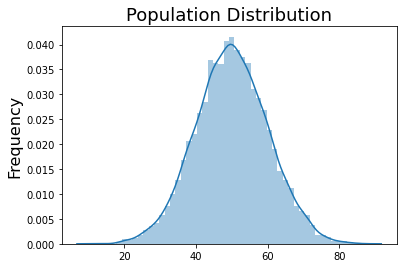

In [107]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

mean = 50
std = 10
population_n = 10000
population = mean + np.random.randn(population_n)*std

sns.distplot(population, kde=True, label='Population')
plt.title('Population Distribution', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

print(f'Population Mean: {np.mean(population):.3}')
print(f'Population Std: {np.std(population):.3}')

Now, let's run a single experiment where we randomly sample 20 participants from the population. You can see that the mean and standard deviation of this distribution are fairly close to the population even though we are not full sampling the distribution.

Sample Mean: 51.4
Sample Std: 9.18


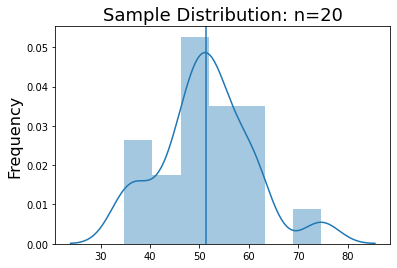

In [114]:
sample_n = 20
sample = np.random.choice(population, size=sample_n, replace=False)

sns.distplot(sample, kde=True, label='Single Sample')
plt.axvline(x=np.mean(sample), ymin=0, ymax=1, linestyle='-')
plt.title(f'Sample Distribution: n={sample_n}', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
      
print(f'Sample Mean: {np.mean(sample):.3}')
print(f'Sample Std: {np.std(sample):.3}')

Now let's estimate the mean of this sample via bootstrapping 5,000 times to estimate our certainty in this estimate from our single small sample.

Bootstrapped Mean: 51.4
Bootstrapped Std: 2.09


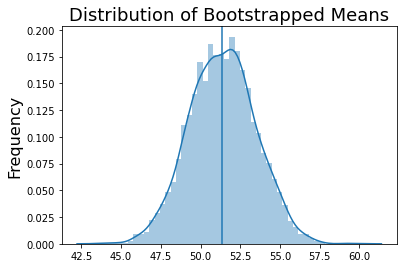

In [115]:
n_bootstrap = 5000

bootstrap_means = []
for b in range(n_bootstrap):
    bootstrap_means.append(np.mean(np.random.choice(sample, size=sample_n, replace=True)))
bootstrap_means = np.array(bootstrap_means)

sns.distplot(bootstrap_means, kde=True, label='Bootstrap')
plt.axvline(x=np.mean(bootstrap_means), ymin=0, ymax=1, linestyle='-')
plt.title('Distribution of Bootstrapped Means', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

print(f'Bootstrapped Mean: {np.mean(bootstrap_means):.3}')
print(f'Bootstrapped Std: {np.std(bootstrap_means):.3}')

From this simulation, we can see that the mean of the bootstraps is the same as the original mean of the sample. 

How confident are we in the precision of our estimated mean? In other words, if we were to look through all 5,000 of our subsamples, how many of them would be close to 50.1? We can define a confidence interval to describe our uncertainty in our estimate. For example, we can use the percentile method to demonstrate the range of the estimated parameter in 95% of our samples. To do this we compute the upper and lower quantiles of our bootstrap estimates centered at 50% (i.e., 2.5% & 97.5%).

Bootstrapped Mean: 51.4
95% Confidence Intervals: [47.4, 55.6]


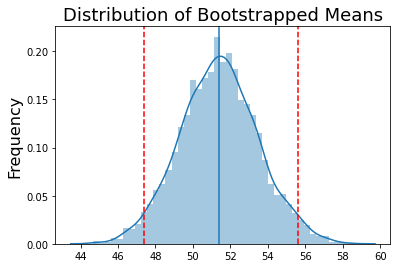

In [116]:
n_bootstrap = 5000

bootstrap_means = []
for b in range(n_bootstrap):
    bootstrap_means.append(np.mean(np.random.choice(sample, size=sample_n, replace=True)))
bootstrap_means = np.array(bootstrap_means)

sns.distplot(bootstrap_means, kde=True, label='Bootstrap')
plt.axvline(x=np.mean(bootstrap_means), ymin=0, ymax=1, linestyle='-')
plt.title('Distribution of Bootstrapped Means', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

plt.axvline(x=lower_bound, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=upper_bound, ymin=0, ymax=1, color='red', linestyle='--')
  
print(f'Bootstrapped Mean: {np.mean(bootstrap_means):.3}')
print(f'95% Confidence Intervals: [{lower_bound:.3}, {upper_bound:.3}]')

The percentile method reveals that 95% of our bootstrap samples lie between the interval [47.4, 55.6]. While the percentile method is easy to compute and intuitive to understand, it has some issues. First, if the original sample was small and not representative of the population, the confidence interval may be biased and too narrow. Second, if the bootstrapped distribution is not symmetric and is skewed, the percentile based confidence intervals will not accurately reflect the distribution. Efron (1987) proposed the bias-corrected and accelerated bootstrap, which attempts to address these issues. We will not be explaining this in detail at the moment and encourage the interested reader to review the original [paper](https://www.jstor.org/stable/pdf/2289144.pdf).


Now let's see how the bootstrap compares to if we had run real independent experiments. Let's simulate 1000 experiments where we randomly sample independent participants from the population and examine the distribution of the means from these independent experiments.

Bootstrapped Mean: 50.0
95% Confidence Intervals: [45.7, 54.3]


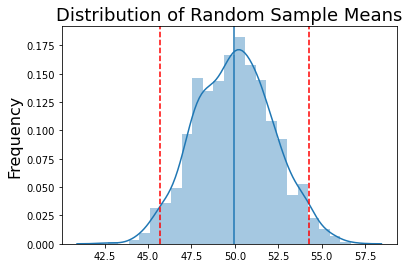

In [117]:
n_samples = 1000

sample_means = []
for b in range(n_samples):
    sample_means.append(np.mean(np.random.choice(population, size=sample_n, replace=False)))
sample_means = np.array(sample_means)

sns.distplot(sample_means, kde=True, label='Random Samples')
plt.axvline(x=np.mean(sample_means), ymin=0, ymax=1, linestyle='-')
plt.title('Distribution of Random Sample Means', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

lower_bound = np.percentile(sample_means, 2.5)
upper_bound = np.percentile(sample_means, 97.5)

plt.axvline(x=lower_bound, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=upper_bound, ymin=0, ymax=1, color='red', linestyle='--')
  
print(f'Bootstrapped Mean: {np.mean(sample_means):.3}')
print(f'95% Confidence Intervals: [{lower_bound:.3}, {upper_bound:.3}]')

We see that the mean is closer to the population mean, but our certainty is approximately equal to what we estimated from bootstrapping a single sample. 

Finally, let's compare the bootstrapped distribution of 20 samples to the 1000 random samples.

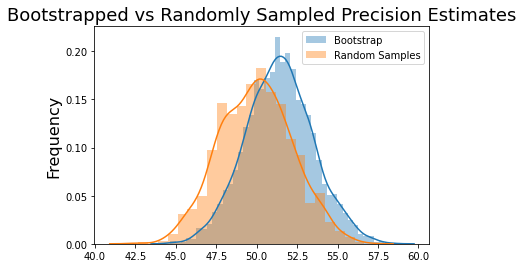

In [118]:
sns.distplot(bootstrap_means, kde=True, label='Bootstrap')
sns.distplot(sample_means, kde=True, label='Random Samples')
plt.title('Bootstrapped vs Randomly Sampled Precision Estimates', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.legend(['Bootstrap', 'Random Samples'])

This technique is certainly not perfect, but it is very impressive how well we can estimate the precision of a population level statistic from a single small experiment using bootstrapping. Though our example focuses on estimating the mean of a population, this approach should work for many different types of estimators. Hopefully, you can see how this technique might be applied to your own work. 

## Permutation Test
After we have estimated a parameter for a sample, we often want to perform a hypothesis test to assess if the observed distribution is statistically different from a null distribution at a specific alpha criterion (e.g., p < 0.05). This is called null hypothesis testing, and classical statistical tests, such as the t-test, F-test, and $\chi^2$ tests, rely on theoretical probability distributions. This can be problematic when your data are not well approximated by the theoretical distributions. Using resampling statistics, we can empirically evaluate the null hypothesis by randomly shuffling the labels and re-running the statistic. Assuming that the labels are exchangeable under the null hypothesis, then the resulting tests yield the exact significance levels, i.e., the number of times we observed our result by chance. This class of non-parametric tests are called permutation tests, and are also occasionally referred to as randomization, re-rerandomization, or exact tests. Assuming the data is exchangeable, permutation tests can provide a "p-value" for pretty much any test statistic regardless if the distribution is known. This provides a relatively straightforward statistic that is easy to compute and understand. Permutation tests can be computationally expensive and often require writing custom code. However, because they are independent they can be run in parallel using multiple CPUs or on a high performance computing system.

### One Sample Permutation Test

Let's simulate some data to demonstrate how to run a permutation test to evaluate if the mean of the simulated sample is statistically different from zero.

We will sample 20 data points from a normal distribution, $\mathcal{N}(\mu=1, \sigma=1)$.

Sample Mean: 0.953
Sample Std: 1.04


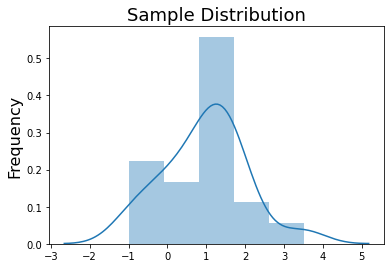

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

mean = 1
std = 1
sample_n = 20
sample = mean + np.random.randn(sample_n)*std

sns.distplot(sample, kde=True, label='Population')
plt.title('Sample Distribution', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

print(f'Sample Mean: {np.mean(sample):.3}')
print(f'Sample Std: {np.std(sample):.3}')

In this example, the null hypothesis is that the sample does not significantly differ from zero. We can empirically evaluate this by randomly multiplying each sample by a $1$ or $-1$ and then calculating the mean for each permutation. This will yield an empirical distribution of null means and we can evaluate the number of times the mean of our sample exceeds the mean of the null distribution.

Sample Mean: 0.953
Null Distribution Mean: 0.00544
n permutations < Sample Mean = 4998
p-value = 0.0004


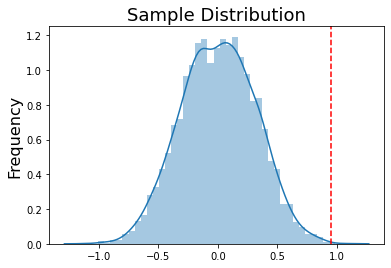

In [19]:
n_permutations = 5000

permute_means = []
for p in range(n_permutations):
    permute_means.append(np.mean(sample * np.random.choice(np.array([1,-1]), sample_n)))
permute_means = np.array(permute_means)

p_value = 1 - np.sum(permute_means < np.mean(sample))/len(permute_means)

sns.distplot(permute_means, kde=True, label='Population')
plt.title('Sample Distribution', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

plt.axvline(x=np.mean(sample), ymin=0, ymax=1, color='red', linestyle='--')

print(f'Sample Mean: {np.mean(sample):.3}')
print(f'Null Distribution Mean: {np.mean(permute_means):.3}')
print(f'n permutations < Sample Mean = {np.sum(permute_means < np.mean(sample))}')
print(f'p-value = {p_value:.3}')


As you can see from a null distribution that it is very rare for us to randomly observe a mean of .953. In fact, this only occurred twice in 5,000 random permutations of the data, which makes our p-value = 0.0004. The precision of our p-value is tied to the number of permutations we run. More samples will allow us to observe a higher precision of our p-value, but will also increase our computation time. We tend to use 5,000 or 10,000 permutations as defaults.

### Two Sample Permutation Test
When we were computed a one-sample permutation test above, we randomly multiplied each data point by a $1$ or $-1$ to create a null distribution. If we are interested in comparing two different groups using a permutation test, we can randomly swap group labels and can recompute the difference between the two distribution. This assumes the data are exchangeable.

Let's start by simulating two different groups. Sample 1 is randomly drawn from this normal distribution, $\mathcal{N}(\mu=10, \sigma=5)$, while Sample 2 is drawn from this normal distribution $\mathcal{N}(\mu=7, \sigma=5)$.



Sample1 Mean: 10.6
Sample1 Std: 4.15
Sample2 Mean: 7.46
Sample2 Std: 5.15


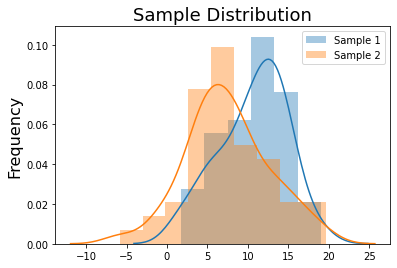

In [36]:
sample_n = 50

mean_1 = 10
std_1 = 5

mean_2 = 7
std_2 = 5

sample_1 = mean_1 + np.random.randn(sample_n)*std_1
sample_2 = mean_2 + np.random.randn(sample_n)*std_2

sns.distplot(sample_1, kde=True, label='Sample 1')
sns.distplot(sample_2, kde=True, label='Sample 2')
plt.title('Sample Distribution', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.legend(['Sample 1', 'Sample 2'])

print(f'Sample1 Mean: {np.mean(sample_1):.3}')
print(f'Sample1 Std: {np.std(sample_1):.3}')

print(f'Sample2 Mean: {np.mean(sample_2):.3}')
print(f'Sample2 Std: {np.std(sample_2):.3}')

Ok, now to compute a permutation test to assess if the two distributions are different, we need to generate a null distribution by permuting the group labels and recalculating the mean difference between the groups. 

Difference between Sample1 & Sample2 Means: 3.16
n permutations < Sample Mean Difference = 4996
p-value = 0.0008


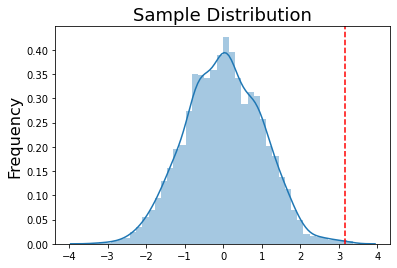

In [37]:
data = pd.DataFrame({'Group':np.ones(len(sample_1)), 'Values':sample_1})
data = data.append(pd.DataFrame({'Group':np.ones(len(sample_2))*2, 'Values':sample_2}))

permute_diffs = []
for p in range(n_permutations):
    permutation_label = np.random.permutation(data['Group'])
    diff = np.mean(data.loc[permutation_label == 1, 'Values']) - np.mean(data.loc[permutation_label == 2, 'Values'])
    permute_diffs.append(diff)
    
difference = np.mean(sample_1) - np.mean(sample_2)
p_value = 1 - np.sum(permute_diffs < difference)/len(permute_means)

sns.distplot(permute_diffs, kde=True, label='Population')
plt.title('Sample Distribution', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

plt.axvline(x=difference, ymin=0, ymax=1, color='red', linestyle='--')

print(f'Difference between Sample1 & Sample2 Means: {difference:.3}')
print(f'n permutations < Sample Mean Difference = {np.sum(permute_diffs < difference)}')
print(f'p-value = {p_value:.3}')


The difference we observed between the two distributions does not occur very frequently by chance. By permuting the labels and recomputing the difference, we found that the sample difference exceeded the permutated label differences 4,996/5000 times.

As long as your data are exchangeable, you can compute p-values for pretty much any type of test statistic using a permutation test. For example, to compute a p-value for a correlation between $X$ and $Y$ you would just shuffle one of the vectors and recompute the correlation. The p-value is the proportion of times that the correlation value exceeds the permuted correlations.

We hope that you will consider using these resampling statistics in your own work. There are many packages in python that can help you calculate bootstrap and permutation tests, but you can see that you can always write your code fairly easily if you understand the core concepts.